In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

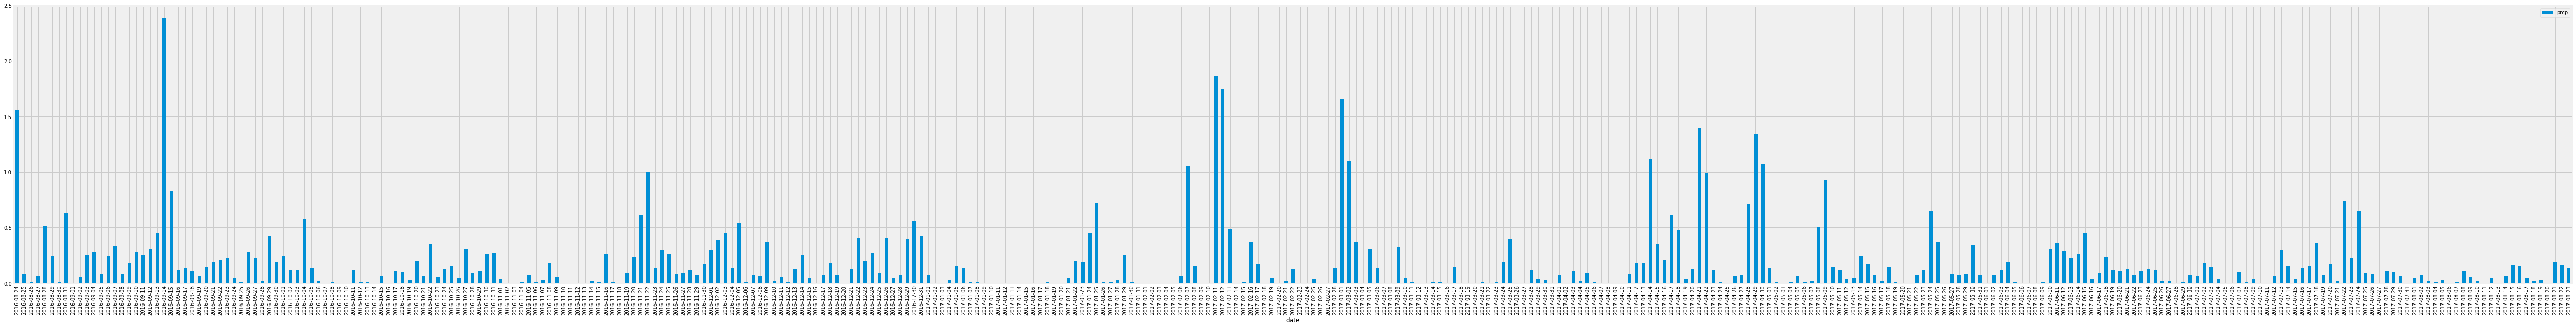

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date="20170823"
last_date=dt.datetime.strptime(last_date,'%Y%m%d')

previous_year=dt.timedelta(days=365)

query_date=last_date - previous_year


# Perform a query to retrieve the data and precipitation scores
result = session.query(Measurement.date, Measurement.prcp, Measurement.tobs).filter(Measurement.date > query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
measure_df=pd.DataFrame(data=result)
# Sort the dataframe by date
measure_df=measure_df.sort_values(by=['date'])
precip_df= measure_df.drop(['tobs'],axis=1)
avgprecip_df=precip_df.groupby('date').mean()
# Use Pandas Plotting with Matplotlib to plot the data
avgprecip_df.plot(figsize=(80,10), kind='bar', label='Precipitation')
plt.title="Precipitation by Date"
plt.yaxis="Preciptation"
plt.xaxis="Date"
plt.savefig('Precipitation.png')
plt.show()


In [15]:
#Writing DataFrame to JSON file
precip_json = avgprecip_df.to_json(path_or_buf="precip_json.json")

In [25]:
#Writing Station JSON file
stat = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()
station_df = pd.DataFrame(data=stat)
station_df.to_json(path_or_buf="station_json.json")

In [28]:
#Writing Tempurature query for last year
tempur = session.query(Measurement.date, Measurement.prcp, Measurement.tobs).filter(Measurement.date > query_date).all()
tempurature_df=pd.DataFrame(data=tempur)
tempurature_df=tempurature_df.sort_values(by=['date'])
tempur_df= tempurature_df.drop(['prcp'],axis=1)
avgtempurature_df=tempur_df.groupby('date').mean()
#Writing Tempurature JSON file
avgtempurature_df.to_json(path_or_buf='temp_json.json')

In [ ]:
stat = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
Station_to_Station_by_David_Bowie = session.query(Station.station).count()
Station_to_Station_by_David_Bowie


9

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_query = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()
station_query

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
minmax_query=session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station=="USC00519281").all()
minmax_query

[(54.0, 85.0, 71.66378066378067)]

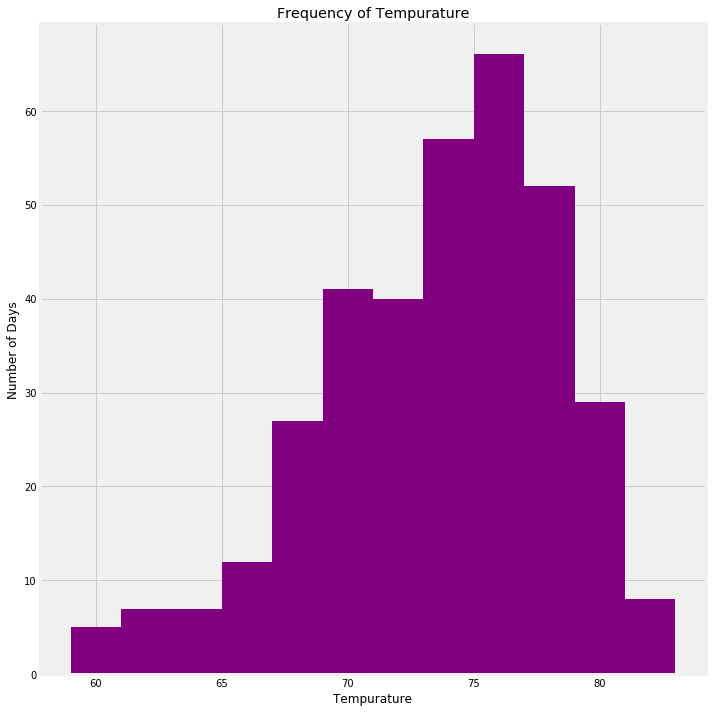

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_query=session.query(Measurement.tobs, Measurement.date).filter(Measurement.station=="USC00519281").filter(Measurement.date > query_date).all()

temps=[station_query[0] for station_query in station_query]


fig, ax = plt.subplots(figsize=(10,10))
ax.hist(temps, bins=12,color="purple",label="# of Days")
ax.set_xlabel("Tempurature")
ax.set_ylabel("Number of Days")
ax.set_title("Frequency of Tempurature")
fig.tight_layout()
plt.savefig("Frequency.png")
plt.show()

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Trip dates: 7/1/2016 to 7/11/2016
trip_temps=calc_temps("2016-07-1","2016-07-11")
trip_temps

[(72.0, 76.0, 80.0)]

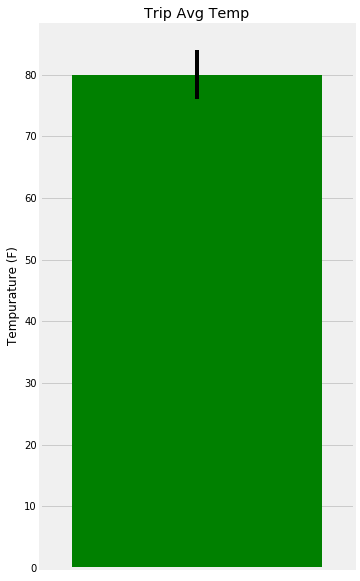

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr=76-72
fig, ax = plt.subplots(figsize=(5,10))
plt.bar(0,trip_temps[0][2],yerr=yerr, color="green")
plt.xlim(-0.5,0.5)
ax.set_ylabel("Tempurature (F)")
ax.set_title("Trip Avg Temp")
ax.get_xaxis().set_visible(False)
plt.show()

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_query= session.query(Measurement.station, Station.name, func.avg(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation).filter(Measurement.date>"2016-07-01").filter(Measurement.date<="2016-07-11").all()
total_query 
#This is the only station that got precipitation results

[('USC00519397',
  'WAIKIKI 717.2, HI US',
  0.1775471698113213,
  21.2716,
  -157.8168,
  3.0)]

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
